In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
usdata = pd.read_pickle("clean_us.pkl")
usdata.head(n=2)

,trending_date,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_date,token_title,token_description
0,2017-11-14,CaseyNeistat,22,17:13:01,[SHANtell martin],748374,57527,2966,15954,False,False,False,2017-11-13,"[we, want, to, talk, about, our, marriage]","[shantell, 's, channel, -, -, this, video, in,..."
1,2017-11-14,LastWeekTonight,24,07:30:00,"[last week tonight trump presidency, last week...",2418783,97185,6146,12703,False,False,False,2017-11-13,"[the, trump, presidency, last, week, tonight, ...","[one, year, after, the, presidential, election..."


In [3]:
usdata.columns

Index(['trending_date', 'channel_title', 'category_id', 'publish_time', 'tags',
       'views', 'likes', 'dislikes', 'comment_count', 'comments_disabled',
       'ratings_disabled', 'video_error_or_removed', 'publish_date',
       'token_title', 'token_description'],
      dtype='object')

In [4]:
usdata.shape

(7139, 15)

In [5]:
#load categorical data
with open ("US_categories.pickle","rb") as f:
    categories = pickle.load(f)
print(categories)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [6]:
usdata["category_name"] = usdata.category_id.map(categories)

In [7]:
usdata.head(n=2)

,trending_date,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_date,token_title,token_description,category_name
0,2017-11-14,CaseyNeistat,22,17:13:01,[SHANtell martin],748374,57527,2966,15954,False,False,False,2017-11-13,"[we, want, to, talk, about, our, marriage]","[shantell, 's, channel, -, -, this, video, in,...",People & Blogs
1,2017-11-14,LastWeekTonight,24,07:30:00,"[last week tonight trump presidency, last week...",2418783,97185,6146,12703,False,False,False,2017-11-13,"[the, trump, presidency, last, week, tonight, ...","[one, year, after, the, presidential, election...",Entertainment


### Exploratory data analysis 

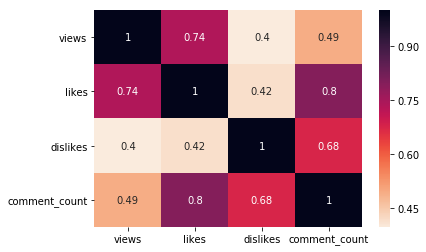

In [8]:
sub = usdata[["views", "likes", "dislikes", "comment_count"]]
corr = sub.corr()
cmap = sns.cm.rocket_r
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap=cmap,
           annot=True)



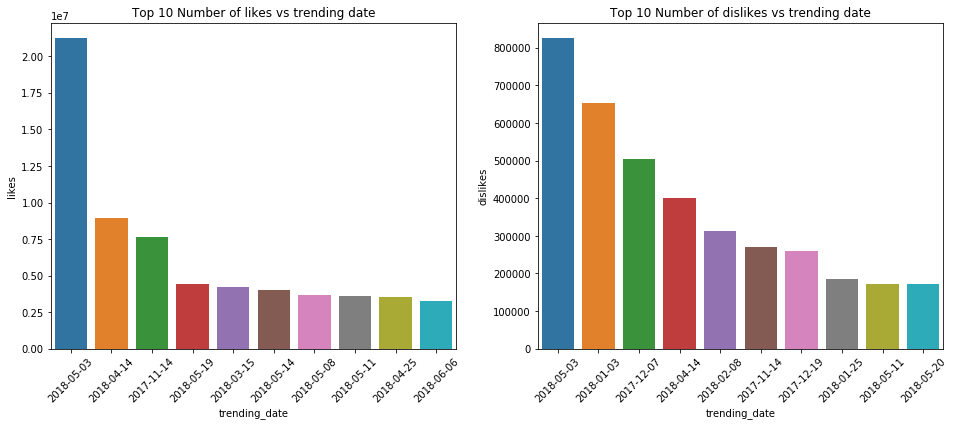

In [9]:
#plt.hist(usdata.trending_date)
agg_reactions = usdata.groupby("trending_date").agg({"likes":"sum", "dislikes":"sum"})
likes_reactions = agg_reactions.sort_values("likes",ascending=False).reset_index()[:10]
dislikes_reactions = agg_reactions.sort_values("dislikes",ascending=False).reset_index()[:10]

#plt.plot(reactions["trending_date"],reactions["likes"])
plt.figure(num=None, figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.barplot(likes_reactions["trending_date"].dt.date,y= likes_reactions["likes"])
plt.xticks(rotation=45)
plt.title("Top 10 Number of likes vs trending date")

plt.subplot(1, 2, 2)
sns.barplot(dislikes_reactions["trending_date"].dt.date,y= dislikes_reactions["dislikes"])
plt.xticks(rotation=45)
plt.title("Top 10 Number of dislikes vs trending date")

plt.show()

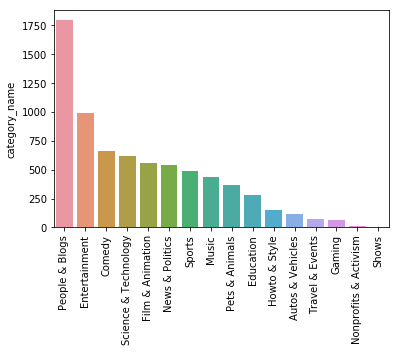

In [10]:
sns.barplot(usdata["category_name"].unique(),usdata["category_name"].value_counts())
plt.xticks(rotation=90)
plt.show()
#The most common category is People & Blogs, followed by Entertainment, then Comedy which has a similar popularity
#to science and Tech.


#### What is the relationship between trending date and the time of publication?


In [ ]:
xx = (usdata["trending_date"] - usdata["publish_date"]).astype('timedelta64[D]').value_counts().reset_index()
xx.rename(index=str, columns={"index": "Diff", 0: "count"},inplace=True)
plt.scatter(xx["Diff"][:25], xx["count"][:25])
plt.xlabel("Difference between publication and trending dates")
plt.ylabel("Count")
plt.title("Count data of duration between publication and trending dates")
plt.show()
#xx.head()

In [ ]:
grp_cats = usdata.groupby("category_id")
#(grp_cats["trending_date"] - grp_cats["publish_date"]).astype('timedelta64[D]').value_counts().reset_index()


#finish grouping by category and look at the differences between publication and trending dates

#### How similar are the various categories to each other?

In [ ]:
mg_cat = usdata.groupby("category_id").agg({"tags":"sum"}).reset_index()

In [ ]:
#index category id
ind_to_cat_id = {idx:cat for idx, cat in enumerate(usdata.category_id.unique())}
cat_id_to_ind = {j:i for i,j in ind_to_cat_id.items()}

In [ ]:
n_feats = 5000
doc_by_vocab = np.empty([len(mg_cat), n_feats])

def build_vectorizer(max_features, stop_words, max_df=0.8, min_df=10, norm='l2'):
    """Returns a TfidfVectorizer object with the above preprocessing properties.
    
    Params: {max_features: Integer,
             max_df: Float,
             min_df: Float,
             norm: String,
             stop_words: String}
    Returns: TfidfVectorizer
    """
    # YOUR CODE HERE
    tfidfvec = TfidfVectorizer(max_features = max_features, stop_words = stop_words, \
                    max_df = max_df, min_df = min_df, norm=norm)
    return tfidfvec

tfidf_vec = build_vectorizer(n_feats, "english")
doc_by_vocab = tfidf_vec.fit_transform([", ".join(d) for d in mg_cat["tags"]]).toarray()
index_to_vocab = {i:v for i, v in enumerate(tfidf_vec.get_feature_names())}

In [ ]:
def get_sim(cat1, cat2, input_doc_mat, cat_name_to_cat_id, cat_id_to_ind):
    """Returns a float giving the cosine similarity of 
       the two categories.
    
    Params: {mov1: String,
             mov2: String,
             input_doc_mat: Numpy Array,
             movie_name_to_index: Dict}
    Returns: Float (Cosine similarity of the two movie transcripts.)
    """
    # YOUR CODE HERE
    catid_1 = cat_name_to_cat_id[cat1]
    catid_2 = cat_name_to_cat_id[cat2]

    script_1 = input_doc_mat[cat_id_to_ind[catid_1],]
    script_2 = input_doc_mat[cat_id_to_ind[catid_2],]
    
    val = np.dot(script_1,script_2.T)/(np.linalg.norm(script_1)*np.linalg.norm(script_2))
        
    return val


In [ ]:
cossim_cat = np.zeros(shape=(len(cat_name_to_cat_id),len(cat_name_to_cat_id)))

for name1,i in cat_name_to_cat_id.items():
    for name2,j in cat_name_to_cat_id.items():
        row = cat_id_to_ind[i]
        col = cat_id_to_ind[j]
        cossim_cat[row,col] = get_sim(name1, name2, doc_by_vocab, cat_name_to_cat_id, cat_id_to_ind)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(cossim_cat, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()
plt.title("Cosine Similarity between the video categories")
plt.xticks(range(len(cat_name_to_cat_id)), cat_name_to_cat_id.keys(), rotation=90)
plt.yticks(range(len(cat_name_to_cat_id)), cat_name_to_cat_id.keys())
plt.show()

In [ ]:
for i in range(cossim_cat.shape[0]):
    print(cat_id_to_cat_name[ind_to_cat_id[i]])
    print("---------------------------")
    top3_idx = np.argsort(cossim_cat[i])[::-1][1:4]
    top3_num = np.sort(cossim_cat[i])[::-1][1:4]
    for j,num in zip(top3_idx,top3_num):
        print(cat_id_to_cat_name[ind_to_cat_id[j]] + " - " + str(num))
    print(" ")

#### What is the relationship between number of comments and up/down-votes?

In [ ]:

dis_like = usdata.groupby("category_name").agg({"likes":"sum", "dislikes":"sum","views":"sum",\
                                              "comment_count": "sum"}).reset_index()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


plt.subplot(1, 3, 1)
sns.barplot(dis_like["category_name"],dis_like["likes"]/dis_like["views"])
plt.ylabel("Ratio of likes to views")
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.barplot(dis_like["category_name"],dis_like["dislikes"]/dis_like["views"])
plt.ylabel("Ratio of dislikes to views")
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.barplot(dis_like["category_name"],dis_like["comment_count"]/dis_like["views"])
plt.ylabel("Ratio of comments to views")
plt.xticks(rotation=90)

plt.show()


In general, videos across all categories are more likely to be liked than disliked. It is also evident that the number of comments have a greater ratio than the dislikes. 

Nonprofts and Activism have the highest ratios among likes, dislikes and comments. People who view videos related to nonprofits and activism are more likely to have a reaction due to the nature of content that is generally portrayed in the video. 

#### Relationship between length of title and popularity 

In [ ]:
title_len = usdata["token_title"].str.len()

udata = pd.DataFrame([title_len,usdata["likes"]]).transpose()
t_len = udata.sort_values("likes",ascending=False).reset_index()[:100]
plt.scatter(x=t_len["token_title"], y=t_len["likes"])
plt.xlabel("length of title")
plt.ylabel("number of likes")
plt.show()


There is no significant evidence of a relationship between length of the title and popularity

#### Relationship between number of words in description and popularity

In [ ]:
des_len = usdata["token_description"].str.len()

udata = pd.DataFrame([des_len,usdata["likes"]]).transpose()
d_len = udata.sort_values("likes",ascending=False).reset_index()[:200]
plt.scatter(x=d_len["token_description"], y=d_len["likes"])
plt.xlabel("number of words in description")
plt.ylabel("number of likes")
plt.show()


There is no significant evidence to conclude that descriptions lengths tell us how popular a video will be.